## Face recognition



Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot some images using the function *'imshow'*.

# Goal
The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Let's load the data.

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
dest_path='./YaleB_32x32.mat')

Load the libraries

In [0]:
import math
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

from scipy import linalg as LA
from scipy.stats import ortho_group

from scipy.io import loadmat

This is a useful function to plot the basis images. Be careful, each row of data is a basis image.

In [0]:
def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())
    #plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)
  

Let's load the data and compute some parameters.

In [0]:
x = loadmat('./YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd']
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square


Let's plot first 10 images of different subjects and then 10 images of the same subject but with different positions and illumination conditions

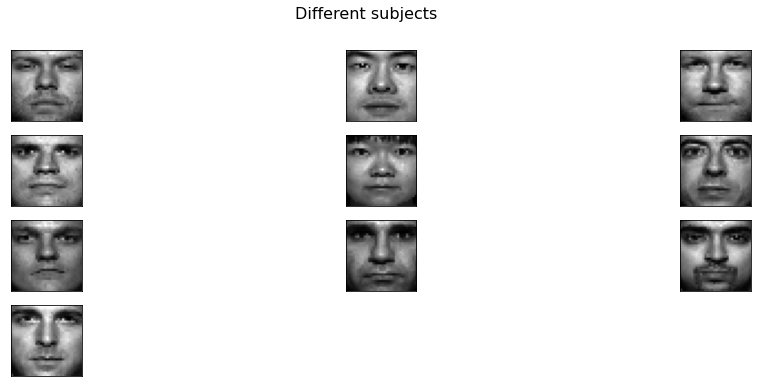

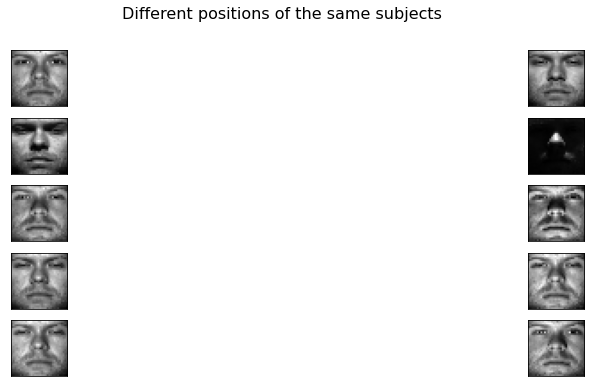

In [5]:
# Plot data      
indexDifferent=np.arange(1,Is*40,Is)     
plotFaces(data,r,c,ncol=3,indeces=indexDifferent[0:10],title='Different subjects')       
indexSame=np.arange(0,10,1)      
plotFaces(data,r,c,ncol=2,indeces=indexSame,title='Different positions of the same subjects')       


In [0]:
# Create train/test split  
trainIdx, testIdx = train_test_split(np.arange(0,data.shape[0],1),test_size=0.3,random_state=1)
Xtest=data[testIdx,:]
Xctest=Xtest-np.mean(Xtest,axis=0) # centering
Xtrain=data[trainIdx,:]
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering
Id_Train = subjectIndex[trainIdx]; # indeces of the subjects for the training
Id_Test = subjectIndex[testIdx]; # indeces of the subjects for the test

N = Xctrain.shape[0] # N number of training images
M = Xctest.shape[0] # M number of test images 

As first idea, we could simply use the pixel intensities as features. This is basically like using the original data, without dimensionality reducton techniques.

In [7]:
## Use the pixel intensities to find the correct subject for the test images
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Xctrain,Id_Train.ravel())
print('Percentage of correct answer using the pixel intensities is ', NN.score(Xctest,Id_Test))


Percentage of correct answer using the pixel intensities is  0.7324137931034482


# PCA

You will first use PCA. Compute the scores, eigenvectors and eigenvalues of the training set. The eigenvectors represent the basis images and they are usually called *'Eigenfaces'*. Then, project both training and test data onto the eigenvectors that explain 95$\%$ of the variability of the training set. You will obtain two vectors of scores which you will use for evaluating the performance of the algorithm. Use the function *'KNeighborsClassifier'* to test the performance.

**Question:** 

1. Use either the scikit-learn implementation or yours (better!) to compute the PCA for the training data-set. Comment the results.
2. Is it worth it in your opinion to compute PCA ? Why ? Hint: think about the performance in your test set and generalizability, so the number of features...

In [0]:
def pcaLecture(X):
    ''' 
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
              column consists of features.
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of X onto the new basis given by the eigenvactors U
            of the covariance matrix of X. Columns are the principal components.
               
            U: columns are Eigenvectors (sorted from the greatest to the lowest eigenvalue)
    
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)
               
            var_explained: percentage of the original variability explained
            by each principal component.
    '''
    d=len(X[0])
    N=X.shape[0]
    Xc=X-np.mean(X,axis=0) # centering
    D2, Uh = LA.svd(Xc)[1:3] # computation of eigenvectors and eigenvalues using SVD
    U=Uh.T
    Y = np.dot(Xc,U) # computation of the scores
    D=D2**2/(N-1) # computation of the eigenvalues
    var_explained=D/np.sum(D) # computation of explained variance
    return Y,U,D,var_explained

PCA my Implementation
Percentage of correct answer using PCA is  0.713103448275862


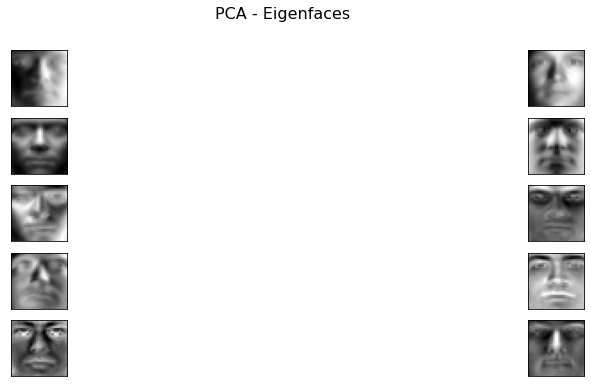

In [9]:
## PCA my implementation
print('PCA my Implementation')
YpcaTrain, UpcaTrain, D, var_explained_pca=pcaLecture(Xctrain)

# Threshold defined as 99% of the variability
Threshold_PCA = 0.99
CumulativePca=np.cumsum(var_explained_pca)
indexPCA=np.argwhere(CumulativePca>Threshold_PCA)
PCAComp=indexPCA[0][0]

# Selection of the eigenvectors 
Yr_train_PCA=YpcaTrain[:,:PCAComp]
Ur_train_PCA=UpcaTrain[:,:PCAComp]

# Computation of the test scores using the eigenvectors computed with the
# training data-set
Yr_test_PCA=np.dot(Xctest,Ur_train_PCA)

# Plot the Eigenfaces
plotFaces(UpcaTrain.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='PCA - Eigenfaces')       

# Score
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Yr_train_PCA,Id_Train.ravel())
print('Percentage of correct answer using PCA is ', NN.score(Yr_test_PCA,Id_Test))


PCA scikit implementation
Percentage of correct answer on train set using PCA is  0.713103448275862


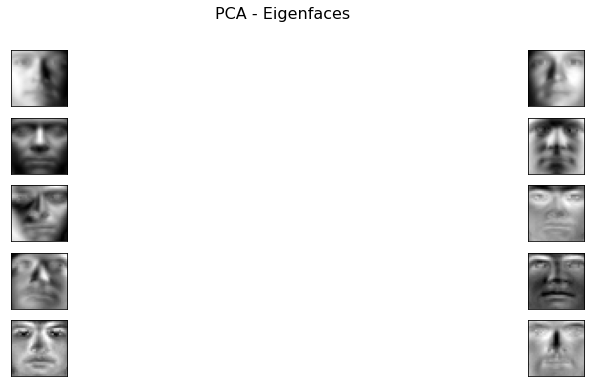

In [10]:
## PCA scikit implementation
print('PCA scikit implementation')
pca = PCA(random_state=1)
Ypca=pca.fit_transform(Xctrain)
U=pca.components_.T

YpcaTrain, UpcaTrain=Ypca,U

# Threshold defined as 99% of the variability
Threshold_PCA = 0.99
CumulativePca=np.cumsum(var_explained_pca)
indexPCA=np.argwhere(CumulativePca>Threshold_PCA)
PCAComp=indexPCA[0][0]

# Selection of the eigenvectors 
Yr_train_PCA=YpcaTrain[:,:PCAComp]
Ur_train_PCA=UpcaTrain[:,:PCAComp]

# Computation of the test scores using the eigenvectors computed with the
# training data-set
Yr_test_PCA=np.dot(Xctest,Ur_train_PCA)

# Plot the Eigenfaces
plotFaces(UpcaTrain.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='PCA - Eigenfaces')       

# Score
NN.fit(Yr_train_PCA,Id_Train.ravel())
print('Percentage of correct answer on train set using PCA is ', NN.score(Yr_test_PCA,Id_Test))



---
__Reponse :__

On obtiens bien les mêmes résultats pour PcaLecture et la fonction PCA de la bibliothèque scikit. 
Cependant, ces résultat sont un peu moins bons que ceux du KNN avant le PCA. L'effet visuel de la réduction de dimension est flagrant, on perd de nombreuses informations. 

Je pense qu'il ne veut mieux pas utiliser PCA, en effet, la généralisation fait référence à la capacité d'un algoithme à être efficace sur différentes entrées (différents types de visages, dans différentes positions ect). Cependant, en diminuant la dimension de nos informations, on perd des features pouvant être intéressantes.

---


# ICA

In the next section tou will evaluate ICA. Every image $x_i$ can be seen as a linear combination of basis images: $x_i=\sum_j c_{ij} b_j$ where $c_{ij}$ is a coefficient and $b_j$ is basis image. ICA can be used in two different ways for face recognition. We can look for a set of statistically independent basis images $b_j$ (first architecture) or for a set of statistically independent coefficients $c_{ij}$ (second architecture).

In the first architecture, we compute $X'=A'S'$, where every row of $X'$ is an image and the columns are pixels. Images are considered as observations and we look for a set of statistically independent basis images contained in the rows of $S'$.

In the second architecture, we transpose the previous setting computing $X''=A''S''$, where every column of $X''$ is an image and rows are pixels. In this case, we consider the pixels as observations and we look for a set of statistically independent coefficients contained in the rows of $S$ and a set of basis images in the columns of $A$.

Instead than using the original training data $X$ as input matrix, we are going to use the eigenvectors (first architecture) or the scores (second architecture) computed with PCA, namely $Y=XL$ (same notation as in the slides of the lecture). In this way, we reduce the computational time since the number of eigenvectors that account for 95\% of the variance of the training images (columns of $L$) is definitely lower than the number of pixels (columns of $X$). If you want, you can of course use the original data but it will take much more time to converge.

For the first architecture we will use $L^T$ as input matrix. In fact, we can notice that the PCA approximation of the matrix $X_{train}$, containing an image in every row, can be written as $\tilde{X}=YL^T$. If we use $L^T$ as input in the ICA algorithm we obtain $L^T=AS$, thus it follows that $\tilde{X}=YW^TS$ (since $A=W^T$). The basis images are contained in the rows of $S$ and the coefficients used for evaluating the performance are instead contained in the rows of $Y_{train}W^T$ for the training set and in $Y_{test}W^T$ for the test set.

For the second architecture, we will instead use $Y^T$ as input matrix. Remember that in the second architecture we want to apply the ICA algorithm to the transpose of $X_{train}$, namely $X^T=AS$. We can notice that, given the PCA transformation $Y=XL$, one can write $AS=Y^T=L^TX^T$ which entails $X^T=LW^TS$. The columns of $LW^T$ contain the basis images whereas the columns of $S$ contain the statistically independent coefficients used to test the performance of the algorithm. For the test set we compute $S_{test}=W_{train}Y_{test}^T$.

**Question:**
 

1.   Implement the two architectures and test their performance. Which one is better ?
2.   Looking at the basis images, in which case do they seem more 'real' ?



---
__Reponse :__
L'architecture 1 obtient un score bien plus élevé que l'architecture 2. L'architecture 1 est donc la meilleure. 
Pourtant quand on regarde les images de base, elles semblent beaucoup plus réelles dans le cas de l'architecture 2. En effet, les images de bases de l'architecture 1 ne ressemblent pas dutout à des visages, on peut éventuellement reconnaître un oeil ou un nez. 
On peut donc se demander si le fait d'obtenir une base d'image semblant réelles est vraiment utile en Machine learning. En effet, la machine traite les informations différements que nous et notre expérience visuelle, et semble trouver des meilleurs résultats pour une base d'image plus abstraite.

---

Percentage of correct answer using ICA arch.1 is  0.7737931034482759


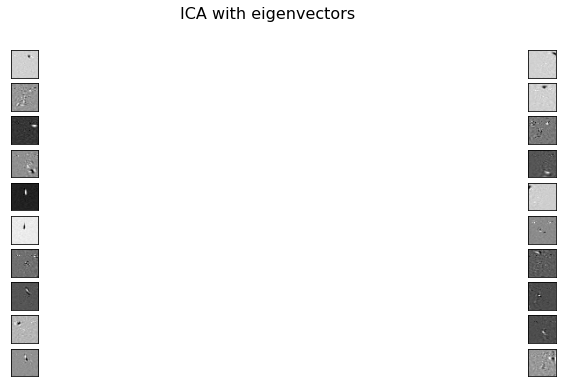

In [17]:
#first architecture
ICA= FastICA(whiten=True, fun='exp', max_iter=30000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(Ur_train_PCA)
Aica=ICA.mixing_

coeff_test= Yr_test_PCA @ Aica
coeff_train= Yr_train_PCA @ Aica

# Plot the Eigenfaces
plotFaces(Yica.T,r,c,ncol=2,indeces=np.arange(0,20,1),title='ICA with eigenvectors')  

# Score
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(coeff_train,Id_Train.ravel())
print('Percentage of correct answer using ICA arch.1 is ', NN.score(coeff_test,Id_Test))

Percentage of correct answer using ICA arch.2 is  0.01793103448275862


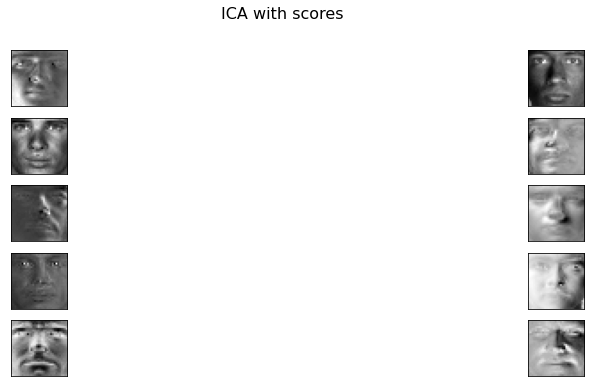

In [18]:
# Second architecture
ICA= FastICA(whiten=True, fun='exp', max_iter=30000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(Yr_train_PCA)
Aica=ICA.mixing_
comp=ICA.components_

im=Ur_train_PCA@Aica

coeff_test= Aica@Yr_test_PCA.T
coeff_train= Yr_train_PCA @ Aica

# Plot the Eigenfaces
plotFaces(im.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA with scores') 

# Score
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Yica.T,Id_Train.ravel())
print('Percentage of correct answer using ICA arch.2 is ', NN.score(coeff_test.T,Id_Test))

# NNMF

Here you will test Non-negative Matrix factorization. The basis images of the training are in the matrix $W_{train}$ and the scores (or coefficients) to test the performance in $H_{train}$. The test scores are computed as $H_{test}=W_{train}X_{test}$.

**Question**


1.   Implement your own implementation following the lecture slides (62,63,64)
2.   Plot the basis images and compare them with respect to the basis images obtained using PCA and ICA
3.   Test the performance of NNMF




In [0]:
def NNMFLecture( X ,r,N_Iter=1000,tol=1e-5,plot_evolution=1):
  '''
  Inputs: 
  %           X: is a [dxN] matrix. Every column (x) is an observation and every
  %           row consists of features.
  %
  %           r: size of the matrices W and H
  %
  %           (Optional) N_Iter: maximum number of iterations
  %
  %           (Optional) tolerance: convergence criteria threshold
  %
  %           (Optional) plot_evolution: plot evolution convergence criteria
  %
  % Outputs:
  %           W: is a [d x r] matrix containing the basis images in its
  %           columns
  %           
  %           H: is a [r x N] matrix containing the loadings (h) in its columns
  %           of the linear combination: x=Wh 
  %
  '''
  d=X.shape[0]
  N=X.shape[1]
  count=0
 
  #Initialization : random 
  W=np.random.rand(d,r)
  H=np.random.rand(r,N)

  threshold=1
  list_thresh=[]

  while ((count<N_Iter) and (threshold>tol)):
    W=W*(X@H.T)/np.dot(W,(H@H.T))
    H=H*(W.T@X)/np.dot(W.T,W@H)
    count+=1
    threshold=np.mean(np.abs((W@H-X)))
    list_thresh.append(threshold)
  if plot_evolution==1:
    plt.plot(np.linspace(0,count,count),list_thresh,marker='+')

  return W,H



Percentage of correct answer using ICA arch.2 is  0.031724137931034485


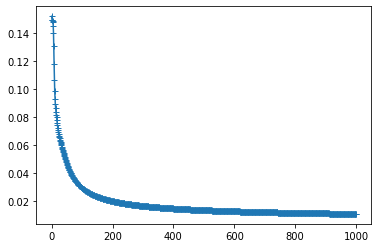

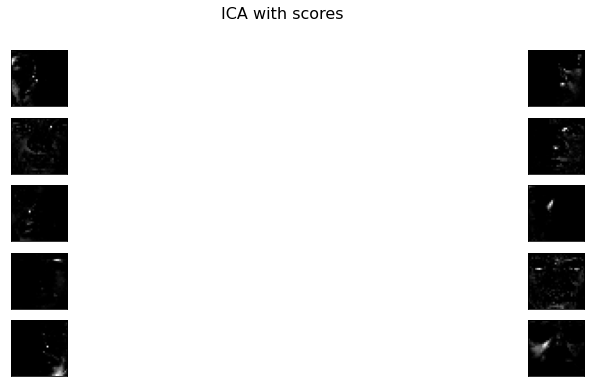

In [19]:
# NNMF
Wtrain,Htrain=NNMFLecture(Xtrain.T,r=int(Xtrain.shape[1]),plot_evolution=1)
Htest=Wtrain.T@Xtest.T

# Plot the Eigenfaces
plotFaces(Wtrain.T ,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA with scores')  

# Score
NN.fit(Htrain.T,Id_Train.ravel())
print('Percentage of correct answer using ICA arch.2 is ', NN.score(Htest.T,Id_Test))

---
__Reponse :__
Les images sont beaucoup plus sombres, on observe des morceaux de visages noyés dans la pénombre. Les visages sont cependant reconnaissables, contrairement au résultats de l'architecture 1 de l'ICA. 
Le test score est encore une fois très mauvais, comme dans le cas de l'architecture 2 de l'ICA. 

---